## Apriori algorithm for ARM


In [1]:
#!pip install tensorflow==2.5.3

In [2]:
import time
start = time.time()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori
#from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import NMF
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import seaborn as sns
import re

import warnings
warnings.simplefilter("ignore", UserWarning)


import warnings
warnings.simplefilter("ignore", UserWarning)

sns.set_style("whitegrid")

cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20','21','22',
        '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("dataset/groceries-1.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
t=df.head(5)
t

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,citrus fruit,semi-finished bread,margarine,ready soups,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,tropical fruit,yogurt,coffee,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,whole milk,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,pip fruit,yogurt,cream cheese,meat spreads,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,other vegetables,whole milk,condensed milk,long life bakery product,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [3]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
count,9835,7676,6033,4734,3729,2874,2229,1684,1246,896,...,14,8,7,7,6,5,4,1,1,1
unique,158,151,155,153,150,137,138,140,128,120,...,13,7,6,7,5,4,3,1,1,1
top,sausage,whole milk,whole milk,whole milk,rolls/buns,soda,soda,shopping bags,soda,shopping bags,...,waffles,bottled beer,chocolate,long life bakery product,hygiene articles,napkins,house keeping products,skin care,hygiene articles,candles
freq,825,654,506,315,176,150,120,76,61,49,...,2,2,2,1,2,2,2,1,1,1


In [4]:
df.dtypes

1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
23    object
24    object
25    object
26    object
27    object
28    object
29    object
30    object
31    object
32    object
dtype: object

In [5]:
df.isnull().sum()

1        0
2     2159
3     3802
4     5101
5     6106
6     6961
7     7606
8     8151
9     8589
10    8939
11    9185
12    9367
13    9484
14    9562
15    9639
16    9694
17    9740
18    9769
19    9783
20    9797
21    9806
22    9817
23    9821
24    9827
25    9828
26    9828
27    9829
28    9830
29    9831
30    9834
31    9834
32    9834
dtype: int64

In [6]:
# check corresponding values
correlation = df.corr()
correlation

""


ValueError: zero-size array to reduction operation fmin which has no identity

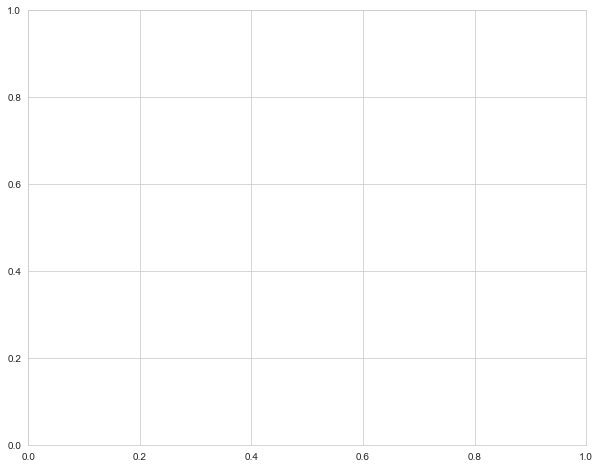

In [7]:
plt.subplots(figsize=(10, 8))
sns.heatmap(correlation, annot=True)

plt.show()

In [ ]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [ ]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items

In [ ]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))


In [ ]:

n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})

In [ ]:

fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [ ]:
records = []
df = pd.read_csv("groceries.csv", sep = ",", names = cols, engine = "python")
for i in range(0, len(df)):
    records.append([str(df.values[i,j]) for j in range(0, 32)])

In [ ]:
association_rules = apriori(records,min_support=0.004, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)
result_apriory = pd.DataFrame()
for item in association_results:
    if len((list(item.ordered_statistics[0].items_base)))< 2:
       continue
    
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    item1=list(item.ordered_statistics[0].items_base)
    if 'nan' in item1: item1.remove('nan')
    if 'None' in item1: item1.remove('None')
    item2=list(item.ordered_statistics[0].items_add)
    if 'nan' in item2: item2.remove('nan')
    if 'None' in item2: item2.remove('None')
    
    print("Rule: " + str(item1) + " -> " + str(item2))

    #second index of the inner list
    print("Support: " + str(item[1]))
    #third index of the list located at 0th 
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    #conviction
    sup=re.sub("[^\d\.]", "", str(item[1]))
    confd=re.sub("[^\d\.]", "", str(item[2][0][2]))
    Convicn=(1-float(sup))/(1-float(confd))
    print("Conviction: " + str(Convicn))
    print("=====================================")
    #print(str(item[2][0][4]))
        
    temp = pd.DataFrame({'item1':[ item1], 'item2': [item2], 'Support': (item[1]), 'Confidence': (item[2][0][2]), 'Lift': (item[2][0][3]), 'Conviction':(Convicn)})
    result_apriory = pd.concat([result_apriory, temp])

result_apriory.to_csv("result_apriory.csv", sep=',')    



In [11]:
end = time.time() 
print("Time consumed in working of Apriori Algorithm: ",end - start)

Time consumed in working of Apriori Algorithm:  48.63667392730713


### now using the set of rules generated by the algorithm

In [8]:
ndf = pd.read_csv("result_apriory.csv", engine = "python")
ndf = ndf.drop('Unnamed: 0', 1)
new_data = np.array(ndf)
re=ndf.head(5)
re

,item1,item2,Support,Confidence,Lift,Conviction
0,"['beef', 'other vegetables']",['pork'],0.004169,0.211340,3.665839,1.262688
1,"['beef', 'other vegetables']",['root vegetables'],0.007931,0.402062,3.688692,1.659150
2,"['beef', 'tropical fruit']",['other vegetables'],0.004474,0.586667,3.031985,2.408531
3,"['beef', 'rolls/buns']",['root vegetables'],0.004982,0.365672,3.354833,1.568616
4,"['beef', 'whole milk']",['root vegetables'],0.008033,0.377990,3.467851,1.594778


In [9]:
ndf

,item1,item2,Support,Confidence,Lift,Conviction
0,"['beef', 'other vegetables']",['pork'],0.004169,0.211340,3.665839,1.262688
1,"['beef', 'other vegetables']",['root vegetables'],0.007931,0.402062,3.688692,1.659150
2,"['beef', 'tropical fruit']",['other vegetables'],0.004474,0.586667,3.031985,2.408531
3,"['beef', 'rolls/buns']",['root vegetables'],0.004982,0.365672,3.354833,1.568616
4,"['beef', 'whole milk']",['root vegetables'],0.008033,0.377990,3.467851,1.594778
5,"['beef', 'yogurt']",['root vegetables'],0.004575,0.391304,3.589998,1.635340
6,"['whole milk', 'berries']",['whipped/sour cream'],0.004270,0.362069,5.050990,1.560873
7,"['butter', 'other vegetables']",['domestic eggs'],0.004575,0.228426,3.600278,1.290123
8,"['whole milk', 'butter']",['domestic eggs'],0.005999,0.217712,3.431409,1.270633
9,"['butter', 'other vegetables']",['root vegetables'],0.006609,0.329949,3.027100,1.482561


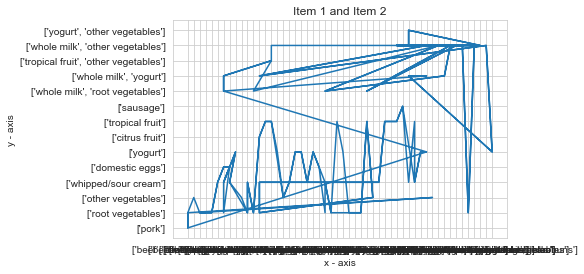

In [10]:
plt.plot(ndf.item1, ndf.item2)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('Item 1 and Item 2')
 
# function to show the plot
plt.show()